# Denoising test

This script does the same as the denoise command (`denoise.py`):
 - load audio file
 - processes it (noise, stft, pre-proc, fragments, normalization)
 - load a trained model
 - predict clean speach
 - unprocess it

On top of that, it allows the user to investigate individual fragments, quickly try different parameters, plot and listen to stuff, etc.   
It's useful for testing trained model, especially while they're being trained!


In [1]:
import os
import time
import sys
import librosa as lr
import librosa.display as lrd
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import mean_squared_error

%matplotlib inline

sys.path.append("..")
from libs.utilities import load_autoencoder_lossfunc, load_autoencoder_model
from libs.processing import pink_noise, \
    make_fragments, unmake_fragments_slice, \
    s_to_exp, exp_to_s, \
    normalize_spectrum, normalize_spectrum_clean, unnormalize_spectrum  


Using TensorFlow backend.
/home/christie/miniconda3/envs/denoising/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
### CONFIGURATION ###

os.environ["CUDA_VISIBLE_DEVICES"] = '1'#'0,1,2,3,4'
input_path = '/data/riccardo_datasets/npr_news/train/newscast220831.wav'
#input_path = '/data/riccardo_datasets/cnn_news/newsday031513.wav'
model_name = 'model_example'
sr = 16000
snr = 4
n_fft = 512
hop_length = 128
win_length = 512
frag_hop_length = 4
frag_win_length = 32
batch_size = 128
normalize = False


In [3]:
### INPUT PROCESSING ###

print('[dn] Loading data from {}...'.format(input_path))
# load data from file name
x, _ = lr.load(input_path, sr=sr, duration=60, offset=20)

# apply noise!
x_noisy = pink_noise(x=x, sr=sr, snr=snr)

# convert to TF-domain
s = lr.stft(x_noisy, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

# make fragments
s_frags_noisy = make_fragments(s, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length)
print('[dn] Generated {} fragments with shape {}'.format(len(s_frags_noisy), s_frags_noisy[0].shape))


# apply pre-processing (data representation)
y_frags_noisy = s_to_exp(exponent=1.0/6)(s_frags_noisy)

# normalize fragments
y_frags_noisy_n = np.empty((y_frags_noisy.shape))
std_frags_noisy = np.empty((len(y_frags_noisy),2))
nf_frags_noisy = np.empty((len(y_frags_noisy),2))
for i in range(len(y_frags_noisy)):
    frag_normalized, frag_norm_factors = normalize_spectrum(y_frags_noisy[i])
    y_frags_noisy_n[i] = frag_normalized if normalize else y_frags_noisy[i]
    nf_frags_noisy[i] = frag_norm_factors


[dn] Loading data from /data/riccardo_datasets/npr_news/train/newscast220831.wav...
[dn] Generated 1868 fragments with shape (257, 32)


In [4]:
#### LOAD TRAINED MODEL ###
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
model_path = '/data/riccardo_models/denoising/model_rnnconv_e99.h5'

time_slice = frag_win_length // 2

print('[dn] Loading model from {}...'.format(model_path))
lossfunc = load_autoencoder_lossfunc(time_slice)
_, _, model = load_autoencoder_model(model_path, {'lossfunc': lossfunc})
# print model summary
#model.summary()

[dn] Loading model from /data/riccardo_models/denoising/model_rnnconv_e99.h5...
[u] Loading loss function for model
[u] Loading autoencoder model from /data/riccardo_models/denoising/model_rnnconv_e99.h5


In [5]:
### PREDICT DATA ###

print('[dn] Predicting with trained model...')
y_frags_pred = model.predict(y_frags_noisy)
print('[dn] Prediction finished! Generated {} fragments'.format(len(y_frags_pred)))

[dn] Predicting with trained model...
[dn] Prediction finished! Generated 1868 fragments


[0, 207, 415, 622, 830, 1037, 1245, 1452, 1660, 1868]


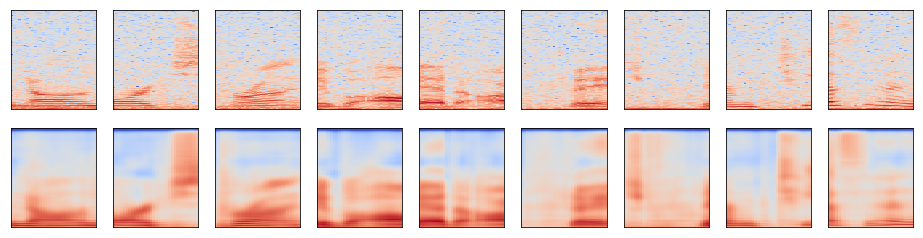

In [6]:
### PLOT A FEW PREDICTED FRAGMENTS ###
specrange = np.linspace(0, len(y_frags_pred), 10, dtype=int)
print(list(specrange))

plt.figure(figsize=(18, 4))
rangespan = len(specrange)
j = 1
y_frags_pred_dn = np.empty((y_frags_pred.shape))
for i in range(len(y_frags_pred)):
    # un-normalize (individually)
    y_frags_pred_dn[i] = unnormalize_spectrum(y_frags_pred[i], nf_frags_noisy[i]) if normalize else y_frags_pred[i]
    if i in specrange:        
        plt.subplot(2,rangespan,j)
        lrd.specshow(lr.amplitude_to_db(y_frags_noisy_n[i,...,0]), vmin=-10, vmax=5, cmap='coolwarm')
        
        plt.subplot(2,rangespan,rangespan+j)
        lrd.specshow(lr.amplitude_to_db(y_frags_pred[i,...,0]), vmin=-10, vmax=5, cmap='coolwarm')
        
        j += 1
        lrd.specshow(lr.power_to_db(np.abs(y_frags_pred[i,...,0])), cmap='coolwarm')
    

In [7]:
### UNPROCESS PREDICTED DATA ###

# clip negative data
#y_frags_pred_dn[y_frags_pred_dn<0]=0

# invert data repr
#s_pred = exp_to_s(1.0/6)(y_frags_pred_dn, s_frags_noisy)
s_pred = exp_to_s(1.0/6)(y_frags_pred, s_frags_noisy)

# undo fragments
s_pred = unmake_fragments_slice(s_pred, frag_hop_len=frag_hop_length, frag_win_len=frag_win_length, time_slice=time_slice)

# get waveform
x_pred = lr.istft(s_pred, hop_length=hop_length, win_length=win_length)


slice(16, 20, None)


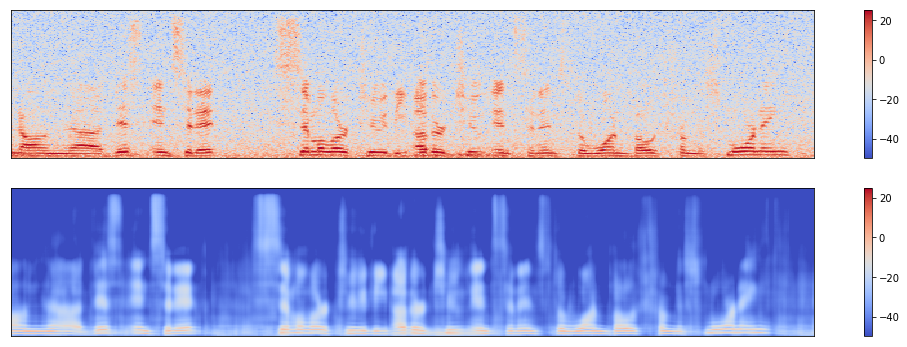

In [12]:
### PLOT RESULT AND LISTEN ###
l = lr.time_to_frames(5, sr=sr, n_fft=n_fft, hop_length=hop_length)

plt.figure(figsize=(18, 6))
plt.subplot(211)
lrd.specshow(lr.amplitude_to_db(np.abs(s[:,:l])), vmin=-50, vmax=25, cmap='coolwarm')
plt.colorbar()
plt.subplot(212)
lrd.specshow(lr.amplitude_to_db(np.abs(s_pred[:,:l])), vmin=-50, vmax=25, cmap='coolwarm')
plt.colorbar()

ipd.Audio(x_pred, rate=sr)

In [9]:
### ORIGINAL AUDIO ###
ipd.Audio(x_noisy, rate=sr)

Text(0.5, 1.0, 'Pred (after processing)')

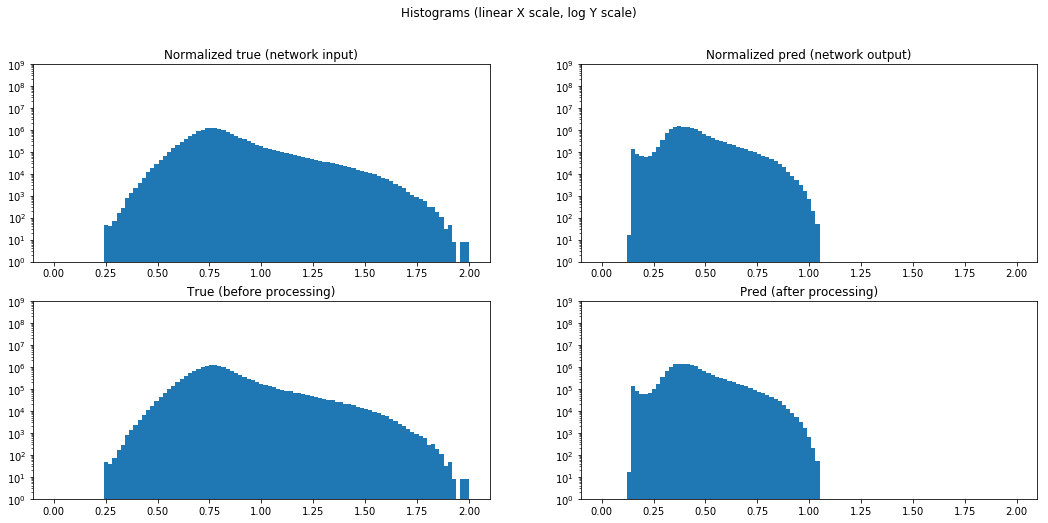

In [10]:
### PLOT HISTOGRAMS ###
plt.figure(figsize=(18, 8))
plt.suptitle('Histograms (linear X scale, log Y scale)')

## normalized
bins = np.linspace(0, 2, 100) #np.logspace(-6, 2, 50)

plt.subplot(221)
counts, bins, bars = plt.hist(y_frags_noisy_n.flatten(), bins=bins)
#plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylim(1, 1e9)
plt.title('Normalized true (network input)')

plt.subplot(222)
counts, bins, bars = plt.hist(y_frags_pred.flatten(), bins=bins)
#plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylim(1, 1e9)
plt.title('Normalized pred (network output)')

## denormalized
bins = np.linspace(0, 2, 100) #np.logspace(-6, 2, 50)

plt.subplot(223)
counts, bins, bars = plt.hist(y_frags_noisy.flatten(), bins=bins)
#plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylim(1, 1e9)
plt.title('True (before processing)')

plt.subplot(224)
counts, bins, bars = plt.hist(y_frags_pred_dn.flatten(), bins=bins)
#plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().set_ylim(1, 1e9)
plt.title('Pred (after processing)')


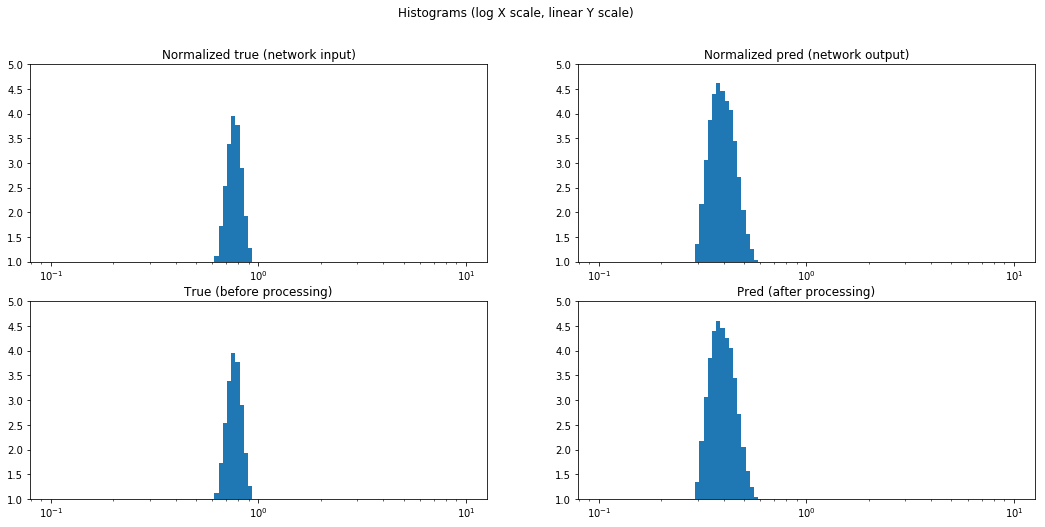

In [11]:
### PLOT HISTOGRAMS (LOG SCALE) ###
bins = np.logspace(-1, 1, 100)
plt.figure(figsize=(18, 8))
plt.suptitle('Histograms (log X scale, linear Y scale)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# normalized
plt.subplot(221)
counts, bins, bars = plt.hist(y_frags_noisy_n.flatten(), bins=bins, density=True)
plt.gca().set_xscale("log")
plt.gca().set_ylim(1, 5)
plt.title('Normalized true (network input)')

plt.subplot(222)
counts, bins, bars = plt.hist(y_frags_pred.flatten(), bins=bins, density=True)
plt.gca().set_xscale("log")
plt.gca().set_ylim(1, 5)
plt.title('Normalized pred (network output)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# denormalized
plt.subplot(223)
counts, bins, bars = plt.hist(y_frags_noisy.flatten(), bins=bins, density=True)
plt.gca().set_xscale("log")
plt.gca().set_ylim(1, 5)
plt.title('True (before processing)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(224)
counts, bins, bars = plt.hist(y_frags_pred_dn.flatten(), bins=bins, density=True)
plt.gca().set_xscale("log")
plt.gca().set_ylim(1, 5)
plt.title('Pred (after processing)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))



In [ ]:
#### WASTELANDS FROM HERE FORTH ####

In [ ]:
print(y_frags_noisy.mean())

In [4]:
#mse = mean_squared_error(np.abs(s), np.abs(s_pred))
#print(mse)

In [5]:
print(mse)

NameError: name 'mse' is not defined

In [ ]:
print(np.mean(np.square(np.abs((y_frags_noisy[...,0]-y_frags_pred[...,0])[...,frag_win_length//2]))))

In [ ]:
y_frags_noisy.min()

In [ ]:
plt.figure(figsize=(18, 6))


x = np.linspace(0,0,128*32) + np.abs(np.random.randn(128*32) * 0.01)
f1 = np.reshape(x, (128, 32))
plt.subplot(221)
lrd.specshow(f1, cmap='gray_r', vmin=0, vmax=1)
plt.colorbar()
plt.title('f1: mean={:.2f} std={:.2f}'.format(f1.mean(), f1.std()))

f2 = np.copy(f1)
x = np.abs(np.random.randn(128*16) )
f2[:,16:] += np.reshape(x, (128, 16))
plt.subplot(222)
lrd.specshow(f2, cmap='gray_r', vmin=0, vmax=1)
plt.colorbar()
plt.title('f2: mean={:.2f} std={:.2f}'.format(f2.mean(), f2.std()))

_, norm_factors = normalize_spectrum(np.concatenate([f1, f2], axis=1))
f1_n = normalize_spectrum_clean(f1, norm_factors)
print(f1_n.shape)
plt.subplot(223)
lrd.specshow(f1_n, cmap='gray_r', vmin=0, vmax=1)
plt.colorbar()
plt.title('f1 norm')

f2_n = normalize_spectrum_clean(f2, norm_factors)
plt.subplot(224)
lrd.specshow(f2_n, cmap='gray_r', vmin=0, vmax=1)
plt.colorbar()
plt.title('f2 norm')

In [ ]:
lr.power_to_db(np.abs(y_frags_pred[...,0])).min()

In [ ]:
from scipy.stats import skew

In [ ]:
skew(y_frags_noisy.flatten())

In [ ]:
lr.amplitude_to_db(y_frags_noisy[i,...,0]).max()